# Investments notebook

This will be the notebook where I do my investment stuff!
Things to do:

- Implement patterns and confirmation: morning/evening star and engulfing patterns!
- Implement stock indicators
- Implement basic screener
- Implement entry rules and position sizing

## 0. Make the necessary imports

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from functions import *

import warnings
warnings.filterwarnings('ignore')

# Import S&P500 data

spx = yf.Ticker("^GSPC")
df_spx = spx.history(period="200d").drop(["Dividends","Stock Splits"], axis = 1)

## 1. Filter for relevant stocks

### 1.1 High volume stocks

Low volume stocks carry a higher risk of investment. Thus, it is recommended to focus our attention is stocks that are traded daily with a high volume. In this section, we consider only the stocks which have been traded consistently with an average volume of 200000 in the past 30 days. Given that this process is time consuming, these stocks are saved in a list of high volume stocks for later use. We recommend to re-run this block at least once per month to guarantee that the list of high volume stocks is up to date.

In [ ]:
# Imports tickers from Nasdaq and NYSE

tickers_nasdaq = pd.read_csv("tickers_nasdaq.csv").Ticker.to_list()
tickers_nyse = pd.read_csv("tickers_nyse.csv").Ticker.to_list()

stock_tickers = tickers_nasdaq + tickers_nyse

# Checks which of the tickers have a volume larger than the 200000 threshold

high_volume_stocks = []

for ticker in stock_tickers:
    
    try:
        if yf.Ticker(ticker).history(period="3mo").Volume.mean() > 200000:
            high_volume_stocks.append(ticker)
            
    except:
        continue
        
# Exports the list of high volume stocks to a data file

pd.DataFrame(high_volume_stocks,columns=["Ticker"]).to_csv("high_volume_stocks.csv")

### 1.2 Relative strength analysis

Relative strength measures how well a stock has performed in comparison with the market indicator, i.e., the S&P500. Long positions for stocks with large relative strengths and short positions for stocks with small relative strengths are less risky than the other way around. Thus, it is recommended that, during an uptrend, one focuses on stocks with large relative strengths, and vice-versa for downtrends. This section filters the high volume stocks and separates them into two lists, one for strong and one for weak stocks, in comparison with the S&P500, in the past 30 days. These lists are saved in a file. It is recommended to run this block at least once per month to guarantee that the lists are updated.

In [ ]:
# Computes the relative change of the SPX in the past 30 days

spx_change = (df_spx.tail(30).iloc[29].Close - df_spx.tail(30).iloc[0].Close) / df_spx.tail(30).iloc[0].Close

# Verifies which of the tickers have a positive or negative growth in comparison with SPX

strong_stocks = []
weak_stocks = []

for stock in high_volume_stocks:
    
    try:
        stock_data = yf.Ticker(stock).history(period="3mo")
        stock_change = (stock_data.tail(30).iloc[29].Close - stock_data.tail(30).iloc[0].Close) / stock_data.tail(30).iloc[0].Close
    
        if stock_change > spx_change:
            strong_stocks.append(stock)
        else:
            weak_stocks.append(stock)
        
    except:
        continue
        
# Exports the lists of strong and weak stocks to data files
        
pd.DataFrame(strong_stocks,columns=["Ticker"]).to_csv("strong_stocks.csv")
pd.DataFrame(weak_stocks,columns=["Ticker"]).to_csv("weak_stocks.csv")

### 1.3 Importing stock lists

If you have already generated the lists of high volume stocks and stocks with strong or weak relative strength in comparison to the S&P500, you can simply run the cell below to import these lists. We recommend re-running the cells above at least once per month to keep the lists updated

In [2]:
# Imports lists of high volume stock and stocks organized by relative strength from files

high_volume_stocks_df = pd.read_csv("high_volume_stocks.csv").Ticker
strong_stocks_df = pd.read_csv("strong_stocks.csv").Ticker
weak_stocks_df = pd.read_csv("weak_stocks.csv").Ticker

## 2. Strategy type selection

### 2.1 Verification of market trend

Use four moving averages with different periods to verify the short-term and long-term trends of the S&P500. This analysis serves to decide wether to go for long or short strategies, when the market is bullish or bearish, respectively. If the market is found to be currently indecisive or trending sideways, it is recommended to stay out of the market. 

In [53]:
# Compute simple moving averages 50, 100, 200 and exponential moving averages 20 and 40

sma_periods = [50, 100, 200]
ema_periods = [20, 40]

for period in sma_periods:
    simple_moving_average(df_spx, period)
    
for period in ema_periods:
    exponential_moving_average(df_spx, period)

# Verifies short- and long-time trends

short_uptrend = (df_spx.tail(1).Close > df_spx.tail(1).EMA20).bool() and (df_spx.tail(1).EMA20 > df_spx.tail(1).EMA40).bool()  
short_downtrend = (df_spx.tail(1).Close < df_spx.tail(1).EMA20).bool() and (df_spx.tail(1).EMA20 < df_spx.tail(1).EMA40).bool()

long_uptrend = (df_spx.tail(1).Close > df_spx.tail(1).SMA50).bool() and (df_spx.tail(1).SMA50 > df_spx.tail(1).SMA100).bool() and (df_spx.tail(1).SMA100 > df_spx.tail(1).SMA200).bool()
long_downtrend = (df_spx.tail(1).Close < df_spx.tail(1).SMA50).bool() and (df_spx.tail(1).SMA50 < df_spx.tail(1).SMA100).bool() and (df_spx.tail(1).SMA100 < df_spx.tail(1).SMA200).bool()

market_uptrend = short_uptrend and long_uptrend
market_downtrend = short_downtrend and long_downtrend

### 2.2 Verification of price oscillation

Even if the market is found to be currently uptrending or downtrending, one might prefer to stay out of the market in case the market is currently overbought or oversold, respectively. To verify wether this is the case, we recur to a simple stochastic indicator. Long strategies are recommended if the market is uptrending and not overbought, whereas short strategies are recommended if the market is downtrending and not oversold. Otherwise, it is recommended to stay out of the market until it regresses to the mean.

In [54]:
# Applies the stochastic oscillator to the data and checks price condition

full_stochastic(df_spx,5,3,3)

market_oversold = (df_spx.tail(1)["Fast K"] < 20).bool() and (df_spx.tail(1)["Slow K"] < 20).bool()
market_overbought = (df_spx.tail(1)["Fast K"] > 80).bool() and (df_spx.tail(1)["Slow K"] > 80).bool()

# Checks trend and price status to decide the strategy type to follow

long_bias = market_uptrend and not market_overbought
short_bias = market_downtrend and not market_oversold

### 2.3 Decision for market strategies

Taking into consideration the trend of the market and the current price status, we conclude which type of strategy to follow. If the market is currently uptrending and not in an overbought state, long positions are recommended. If the market is currently downtrending and not in an oversold state, short positions are recommended. Otherwise, it is recommended to stay inective until the market retraces.

Market is currently good for long positions.


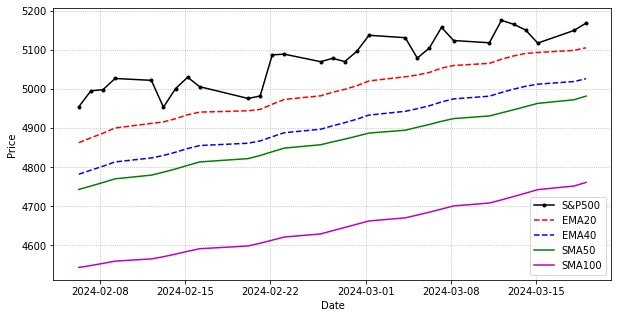

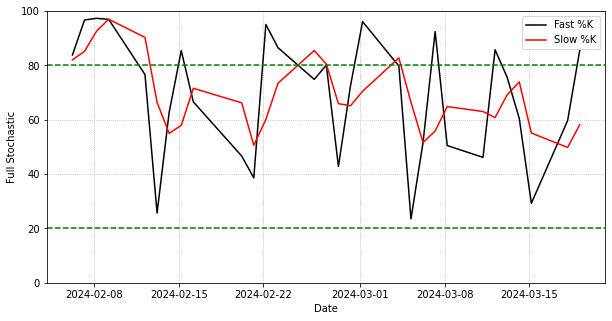

In [55]:
# Analyzed the trend and price status of the market and concludes which strategies are recommended

if market_uptrend and not market_overbought:
    stocks_to_screen = strong_stocks_df
    print("Market is currently good for long positions.")
    
elif market_downtrend and not market_oversold:
    stocks_to_screen = weak_stocks_df
    print("Market is currently good for short positions.")
    
else:
    print("Market is currently indecisive.")
    
# Plots the SPX and respective moving averages
    
plt.figure(figsize=(10, 5))
plt.plot(df_spx.tail(30).Close, 'k.-', label='S&P500')
plt.plot(df_spx.tail(30).EMA20, 'r--', label='EMA20')
plt.plot(df_spx.tail(30).EMA40, 'b--', label='EMA40')
plt.plot(df_spx.tail(30).SMA50, 'g-', label='SMA50')
plt.plot(df_spx.tail(30).SMA100, 'm-', label='SMA100')
plt.grid(linestyle=':')
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

# Plots the RSI indicator of the SPX

plt.figure(figsize=(10, 5))
plt.plot(df_spx.tail(30)["Fast K"], 'k-', label='Fast %K')
plt.plot(df_spx.tail(30)["Slow K"], 'r-', label='Slow %K')
plt.axhline(y=80, color='g', linestyle='--')
plt.axhline(y=20, color='g', linestyle='--')
plt.grid(linestyle=':')
plt.ylim(0,100)
plt.xlabel("Date")
plt.ylabel("Full Stochastic")
plt.legend()
plt.show()

## 3. Strategy screeners

### 3.1 Basic strategy for bullish markets

Note: we recommend using this strategy when the market is bullish and with strong stocks.

The first strategy in this notebook consists of a basic strategy that takes into account the convergence of four different signals: 

- Signal 1: the price is currently on a downtrend
- Signal 2: the MACD indicator is currently bullish
- Signal 3: the RSI indicator is currently oversold
- Signal 4: a bullish candlestick pattern is detected

If the four signals are detected, a long position is recommended for the stock under consideration.

In [6]:
for stock in weak_stocks_df.to_list()[0:500]:
    
    try:
        ticker = yf.Ticker(stock)
        df_ticker = ticker.history(period="1mo").drop(["Dividends","Stock Splits"], axis = 1)
    
        signal = pattern_bearish_engulfing(df_ticker,confirmation=True)
    
    except:
        continue
        
    print(stock+": "+str(signal))
    

AAGR: False
AAL: False
AAOI: False
AAPL: False
AAPU: False
AAXJ: False
ABAT: False
ABCB: False
ABCL: False
ABUS: True
ABVC: False
ACAD: False
ACB: False
ACCD: False
ACET: False
ACHC: False
ACIC: False
ACLS: False
ACON: False
ACRS: False
ADBE: False
ADD: False
ADEA: False
ADI: False
ADP: False
ADPT: False
ADSK: False
ADTN: False
ADTX: False
ADVM: False
AEHR: False
AEIS: False
AEY: False
AFRM: False
AGEN: False
AGFY: False
AGNC: False
AGRI: False
AGRX: False
AGYS: False
AIQ: False
AKAM: False
AKAN: False
AKTS: False
AKYA: False
ALCE: False
ALDX: False
ALEC: False
ALGM: False
ALGT: False
ALHC: False
ALKS: False
ALKT: False
ALLK: False
ALNY: False
ALT: False
ALTO: False
ALTR: False
ALVO: False
ALXO: False
AMAM: False
AMBA: False
AMCX: False
AMED: False
AMGN: False
AMKR: False
AMLI: False
AMLX: False
AMPH: False
AMPL: False
AMRK: False
AMRN: False
AMTX: False
AMZN: False
AMZU: False
ANAB: False
ANGL: False
ANGO: False
ANSS: False
ANTX: False
ANY: False
API: False
APLD: False
APLM: False
APL

CHEA: No price data found, symbol may be delisted (period=1mo)


CGTX: False
CHDN: False
CHKP: False
CHRW: False
CHTR: False
CIBR: False
CING: False
CISO: False
CISS: False
CKPT: False
CLFD: False
CLNE: False
CLNN: False
CLOU: False
CLOV: False
CMCSA: False
CMND: False
CMPS: False
CMRX: True
CMTL: False
CNDT: False
CNEY: False
CNSL: False
CNVS: False
CNXA: False
CNXC: False
COEP: True
COHU: False
COLB: False
COLM: False
COMM: False
CORZ: False
COSM: True
COST: False
CPSI: False
CRBU: False
CRCT: False
CRDO: False
CRGE: False
CRKN: False
CRNC: False
CRON: False
CRSR: False
CRVS: False
CSCO: False
CSIQ: True
CSQ: False
CSSE: False
CSTL: False
CSWC: False
CSX: False
CTAS: False
CTKB: False
CTLP: False
CTRM: False
CTSH: False
CTSO: False
CUE: False
CUTR: False
CVAC: False
CVBF: False
CVII: False
CVKD: False
CXDO: False
CYN: False
CYRX: False
CYTK: False
CYTO: False
CZR: False
DAWN: True
DBX: False
DCFC: False
DCOM: False
DCPH: False
DCTH: False
DDOG: False
DENN: False
DERM: False
DGHI: False
DGRW: False
DH: False
DHC: False
DIOD: False
DKNG: False
DLO: 

In [11]:
ticker = yf.Ticker("BLBD")
df_ticker = ticker.history(period="1mo").drop(["Dividends","Stock Splits"], axis = 1)

body_and_range(df_ticker)

df_ticker.tail(4)

,Open,High,Low,Close,Volume,Body,Range
Date,,,,,,,
2024-03-14 00:00:00-04:00,33.150002,33.279999,31.719999,32.040001,358400,1.110001,1.559999
2024-03-15 00:00:00-04:00,31.900000,32.424999,31.421000,31.799999,646300,0.100000,1.004000
2024-03-18 00:00:00-04:00,32.060001,32.779999,31.860001,32.580002,228800,0.520000,0.919998
2024-03-19 00:00:00-04:00,32.509998,34.250000,31.995001,34.240002,542300,1.730003,2.254999


In [2]:

pattern_bullish_pinbar(df_spx,confirmation=False)

False

### 3.2 Basic strategy for bearish markets

Note: we recommend using this strategy when the market is bearish and with weak stocks.

The first strategy in this notebook consists of a basic strategy that takes into account the convergence of four different signals: 

- Signal 1: the price is currently on a uptrend
- Signal 2: the MACD indicator is currently bearish
- Signal 3: the RSI indicator is currently overbought
- Signal 4: a bearish candlestick pattern is detected

If the four signals are detected, a short position is recommended for the stock under consideration.

# WHATEVER IS AFTER THIS IS NOT IMPLEMENTED!

## 4. Order placement

### 4.1 Entry rules

### 4.2 Position sizing

## 5. Backtesting